In [183]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [184]:
#%reset

In [185]:
import fenics
import mshr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import io
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import imageio

In [186]:
plt.style.use('dark_background')

In [187]:
class IFunc:

  def __call__(self):
    raise NotImplementedError("call method not implemented")

  def __str__(self):
    raise NotImplementedError("str method not implemented")

In [188]:
class BaseFunc(IFunc):

  def __call__(self):
    return fenics.Expression(str(self), **self.params)

$$\alpha ⋅\cos{x}$$

In [189]:
class Function(BaseFunc):

  def __init__(self, cpp_code='', **kwargs):
    self.cpp_code = cpp_code
    self.params = kwargs

  def __str__(self):
    return self.cpp_code

In [190]:
class ConstFunction(BaseFunc):

  def __init__(self, value=0):
    self.value = value

  def __call__(self):
    return fenics.Constant(self.value)

In [191]:
class PolarFunction(Function):

  r = fenics.Expression("sqrt(x[0]*x[0] + x[1]*x[1])", degree = 2)
  phi = fenics.Expression("atan2(x[1], x[0])", degree = 2)

  def __call__(self):
    return fenics.Expression(str(self), r=self.r, phi=self.phi, **self.params)

In [192]:
class MySolver:

  def _configure_domain(self, domain, n_meshes, n_dim):
    self.domain = domain
    self.mesh = mshr.generate_mesh(self.domain, n_meshes)
    self.V = fenics.FunctionSpace(self.mesh, 'P', n_dim)

  @staticmethod
  def boundary(x, on_boundary):
    return on_boundary# and x[0] < 0

  def _configure_bc(self, h, g):
    self.bc = fenics.DirichletBC(self.V, h, self.boundary)
    self.bc_der = g

  def _configure_load(self, f):
    self.p = f

  def _configure_var_problem(self, alpha):
    u = fenics.TrialFunction(self.V)
    v = fenics.TestFunction(self.V)
    
    self.a = (fenics.dot(fenics.grad(u), fenics.grad(v)) + alpha * u * v)*fenics.dx
    self.L = self.p*v*fenics.dx + self.bc_der * v * fenics.ds 

  def _configure(self, f, h, g, alpha):
    # self._configure_domain()
    self._configure_bc(h, g)
    self._configure_load(f)
    self._configure_var_problem(alpha)

  def get_values(self, sol):
    return sol.compute_vertex_values(self.mesh)    

  def expr_to_func(self, expr):
    func = fenics.Function(self.V)
    func.vector()[:] = fenics.project(expr, self.V).vector()
    return func

  def solve(self, f : fenics.Expression, h : fenics.Expression, g : fenics.Expression, alpha=1):
    self._configure(f, h, g, alpha)    

    u = fenics.Function(self.V)
    fenics.solve(self.a == self.L, u, self.bc)
    #   Plot solution
    #p = fenics.interpolate(self.p, self.V)
    return u#, p

  def __init__(self, domain, n_meshes, n_dim):
    self._configure_domain(domain, n_meshes, n_dim)


In [193]:
from matplotlib.tri import triangulation
class Plotter:

  @staticmethod
  def make_triangulation(mesh):
    coords = mesh.coordinates()
    print(len(mesh.cells()), len(coords))
    triangulation = tri.Triangulation(coords[:, 0], coords[:, 1], mesh.cells())
    return triangulation

  @classmethod
  def plot_u(cls, triangulation, colors, title='', vmin=None, vmax=None):
    if vmin==None or vmax==None:
      vmin = np.min(colors)
      vmax = np.max(colors)
    plt.figure(figsize = (5, 5))
    plt.grid()
    plt.title(title)
    plt.tripcolor(triangulation, colors, cmap='plasma', vmin=vmin, vmax=vmax)
    plt.colorbar()

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    plt.close()
    img = Image.open(img_buf)
    return img

  @classmethod
  def combine_plots(cls, imgs):
    widths, heights = zip(*(i.size for i in imgs))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))

    offset = 0
    for im in imgs:
      new_im.paste(im, (offset,0))
      offset += im.size[0]
    
    return new_im

  @classmethod
  def plot_multiple(cls, imgs):
    return cls.combine_plots(imgs)

  @classmethod
  def evaluate(cls, solver, f, h, g, u_true, alpha=5):
    u = solver.solve(f, h, g, alpha=alpha)
    u_true_func = solver.expr_to_func(u_true)

    pred_colors = solver.get_values(u)
    true_colors = solver.get_values(u_true_func)
    diff_colors = np.abs(pred_colors - true_colors)

    return u, u_true_func, pred_colors, true_colors, diff_colors

  @classmethod
  def plot(cls, triangulation, pred_colors, true_colors, diff_colors, vmin=None, vmax=None, err_vmin=None, err_vmax=None):
    if vmin == None or vmax == None:
      vmin = np.min(np.concatenate((pred_colors, true_colors)))
      vmax = np.max(np.concatenate((pred_colors, true_colors)))

    if err_vmin == None or err_vmax == None:
      err_vmin = np.min(diff_colors)
      err_vmax = np.max(diff_colors)

    img = cls.plot_u(triangulation, pred_colors, title='numerical solution', vmin=vmin, vmax=vmax)
    img_true = cls.plot_u(triangulation, true_colors, title='exact solution', vmin=vmin, vmax=vmax)
    diff = cls.plot_u(triangulation, diff_colors,title='deflection', vmin=err_vmin, vmax=err_vmax)
    return cls.plot_multiple((img, img_true, diff))

In [194]:
solver = MySolver(mshr.Circle(fenics.Point(0, 0), 1), 10, 2)
mesh = solver.mesh
triangulation = Plotter.make_triangulation(mesh)
alpha=5

392 228


# п.1



$$u = r^2 \cdot cos(\phi) + 1$$
$$Δu = 3\cos(\phi)$$
$$u|_{r=1}=\cos(\phi) + 1$$
$$\frac{∂ u}{∂ n}|_{r=1} = 2⋅\cos(\phi) + 1$$

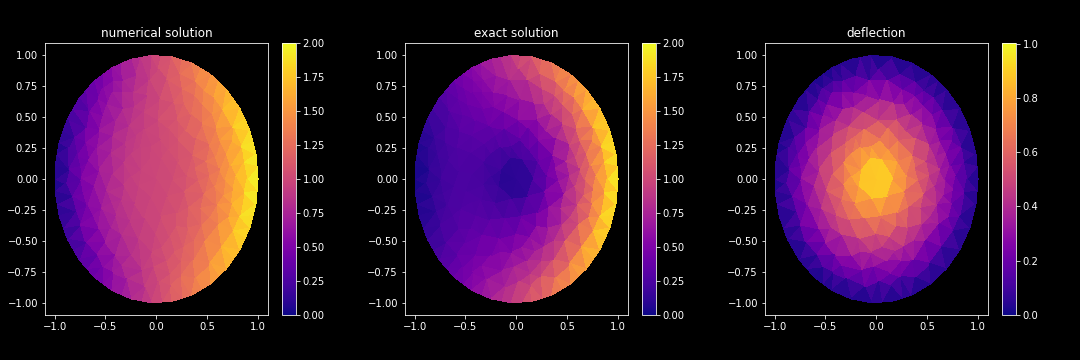

In [195]:
_,_,pred_colors, true_colors, diff_colors = Plotter.evaluate(
    solver,
    PolarFunction("-3*cos(phi) + alpha*(r*r*cos(phi) + 1)", alpha=5, degree=2)(),
    PolarFunction("cos(phi) + 1", degree=2)(),
    PolarFunction("2*cos(phi)+1", degree=2)(),
    PolarFunction("r*r*cos(phi) + r", degree=2)()
)
Plotter.plot(
    triangulation,
    pred_colors, true_colors, diff_colors
)

$$u = r^2 \cdot cos(4\pi r)$$
$$Δu = -16 π^2 r^2 cos(4 π r) - 20 π r sin(4 π r) + 4 cos(4 π r)$$
$$u|_{r=1}=1$$
$$\frac{∂ u}{∂ n}|_{r=1} = 2$$

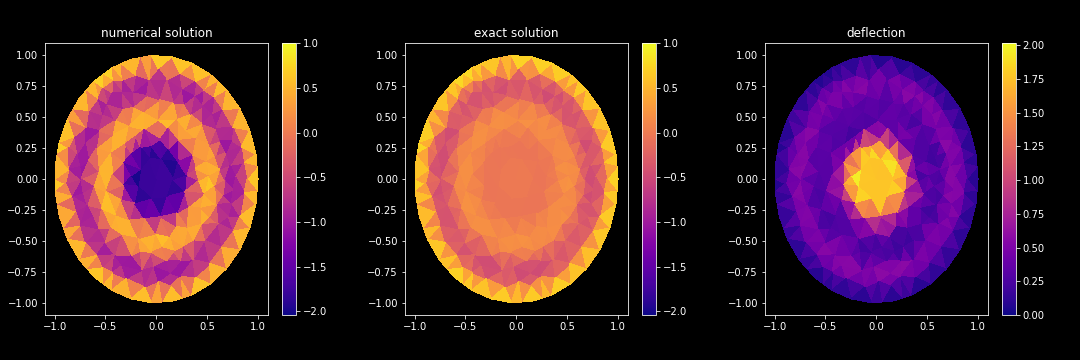

In [197]:
_,_,pred_colors, true_colors, diff_colors = Plotter.evaluate(
    solver,
    PolarFunction("16 * pi * pi * cos(4*pi*r) + 20 * pi * r * sin(4*pi*r) - 4 * cos(4*pi*r) + alpha*(r*r*cos(4*pi*r))", alpha=5, degree=2)(),
    ConstFunction(1)(), 
    ConstFunction(2)(),
    PolarFunction("r*r*cos(4*pi*r)", degree=2)()
)
Plotter.plot(
    triangulation,
    pred_colors, true_colors, diff_colors
)

$$u = 1/3\cdot r^3 sin(\phi)$$
$$Δu = 8/3 \cdot r \cdot sin(\phi)$$
$$u|_{r=1}= 1/3 \cdot sin(\phi)$$
$$\frac{∂ u}{∂ n}|_{r=1} = sin(\phi)$$

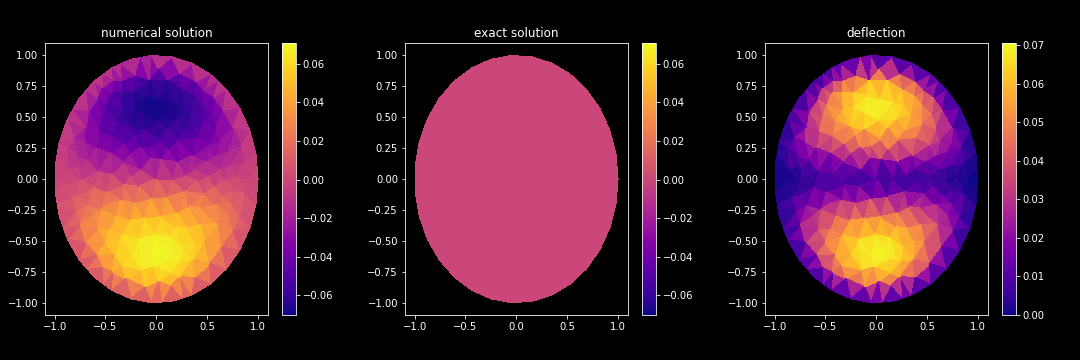

In [198]:
_,_,pred_colors, true_colors, diff_colors = Plotter.evaluate(
    solver,
    PolarFunction("-8/3*r*sin(phi) + alpha*(1/3*r*r*r*sin(phi))", alpha=5, degree=2)(),
    PolarFunction("1/3*sin(phi)", degree=2)(),
    PolarFunction("sin(phi)", degree=2)(),
    PolarFunction("1/3*r*r*r*sin(phi)", degree=2)()
)
Plotter.plot(
    triangulation,
    pred_colors, true_colors, diff_colors
)

# п.2

In [199]:
T = 2.0
n_iters = 10
dt = T / n_iters
solver = MySolver(mshr.Circle(fenics.Point(0, 0), 1), 10, 2)
mesh = solver.mesh
triangulation = Plotter.make_triangulation(mesh)
alpha = fenics.Constant(1)

392 228


In [200]:
t = 0
pred_colors=[] 
true_colors=[] 
diff_colors=[]

L2_errors = []
max_errors = []

file_name = "test_01.gif"
h = PolarFunction("t * (cos(phi) + 1)", t=t, degree=2)()
u_n = fenics.interpolate(h, solver.V)

for i in tqdm(range(n_iters)):
  t += dt
  f = PolarFunction("r * r * cos(phi) + 1 - (3 *t * cos(phi))", t=t, degree=2)()
  h = PolarFunction("t * (cos(phi) + 1)", t=t, degree=2)()
  g = PolarFunction("t * (2 * cos(phi))", t=t, degree=2)()
  u_true = PolarFunction("t * (r * r * cos(phi) + 1)", t=t, degree=2)()

  u, u_true, pred, true, diff = Plotter.evaluate(
      solver,
      u_n / (dt * alpha) + f / alpha, 
      h, 
      g, 
      u_true,
      alpha=1/(dt * alpha)
  )
  L2_errors.append(fenics.errornorm(u_true, u, 'L2'))
  max_errors.append(np.max(diff))

  u_n.assign(u)

  pred_colors.append(pred)
  true_colors.append(true)
  diff_colors.append(diff)
frame_values = np.array([[pred, true] for pred, true in zip(pred_colors, true_colors)])
diff_values = np.array(diff_colors)
vmin = np.min(frame_values)
vmax = np.max(frame_values)

err_vmin = np.min(diff_values)
err_vmax = np.max(diff_values)

frames = []
for pred, true, diff in zip(pred_colors, true_colors, diff_colors):
  frames.append(
      Plotter.plot(
          triangulation,
          pred, true, diff,
          vmin=vmin, vmax=vmax, err_vmin=err_vmin, err_vmax=err_vmax
      )
  )
imageio.mimsave(f"/content/sample_data/{file_name}", [np.array(f) for f in frames], fps=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/10 [00:00<?, ?it/s]

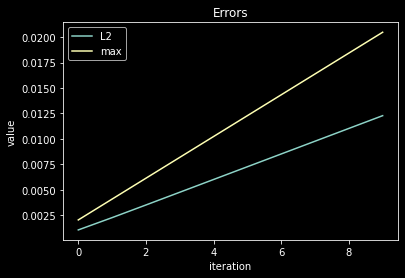

In [201]:
plt.title("Errors")
plt.plot(L2_errors, label='L2')
plt.plot(max_errors, label='max')
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()

In [204]:
t = 0
pred_colors=[] 
true_colors=[] 
diff_colors=[]

L2_errors = []
max_errors = []

file_name = "test_02.gif"
h = ConstFunction(1)()
u_n = fenics.interpolate(h, solver.V)

for i in tqdm(range(n_iters)):
  t += dt
  f = PolarFunction("r * r * cos(4*pi*r) - t*(4*cos(4*pi*r) - 12*pi*r*sin(4*pi*r)-2*r*sin(4*pi*r)-16*pi*pi*r*r*cos(4*pi*r))", t=t, degree=2)()
  h = PolarFunction("t", t=t, degree=2)()
  g = PolarFunction("2*t", t=t, degree=2)()
  u_true = PolarFunction("t * (r * r * cos(4 * pi *r))", t=t, degree=2)()

  u, u_true, pred, true, diff = Plotter.evaluate(
      solver,
      u_n / (dt * alpha) + f / alpha, 
      h, 
      g, 
      u_true,
      alpha=1/(dt * alpha)
  )
  L2_errors.append(fenics.errornorm(u_true, u, 'L2'))
  max_errors.append(np.max(diff))

  u_n.assign(u)

  pred_colors.append(pred)
  true_colors.append(true)
  diff_colors.append(diff)
frame_values = np.array([[pred, true] for pred, true in zip(pred_colors, true_colors)])
diff_values = np.array(diff_colors)
vmin = np.min(frame_values)
vmax = np.max(frame_values)

err_vmin = np.min(diff_values)
err_vmax = np.max(diff_values)

frames = []
for pred, true, diff in zip(pred_colors, true_colors, diff_colors):
  frames.append(
      Plotter.plot(
          triangulation,
          pred, true, diff,
          vmin=vmin, vmax=vmax, err_vmin=err_vmin, err_vmax=err_vmax
      )
  )
imageio.mimsave(f"/content/sample_data/{file_name}", [np.array(f) for f in frames], fps=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/10 [00:00<?, ?it/s]

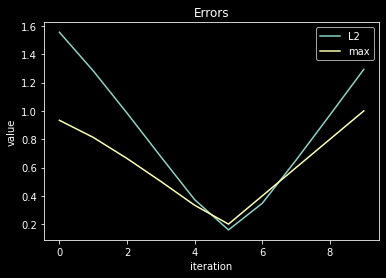

In [203]:
plt.title("Errors")
plt.plot(L2_errors, label='L2')
plt.plot(max_errors, label='max')
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()

In [206]:
t = 0
pred_colors=[] 
true_colors=[] 
diff_colors=[]

L2_errors = []
max_errors = []

file_name = "test_03.gif"
h = ConstFunction(1)()
u_n = fenics.interpolate(h, solver.V)

for i in tqdm(range(n_iters)):
  t += dt
  f = PolarFunction("1/3*r*r*r*sin(phi) - 8/3*r*t*sin(phi)", t=t, degree=2)()
  h = PolarFunction("1/3*sin(phi)*t", t=t, degree=2)()
  g = PolarFunction("sin(phi)*t", t=t, degree=2)()
  u_true = PolarFunction("1/3*r*r*r*sin(phi)*t", t=t, degree=2)()

  u, u_true, pred, true, diff = Plotter.evaluate(
      solver,
      u_n / (dt * alpha) + f / alpha, 
      h, 
      g, 
      u_true,
      alpha=1/(dt * alpha)
  )
  L2_errors.append(fenics.errornorm(u_true, u, 'L2'))
  max_errors.append(np.max(diff))

  u_n.assign(u)

  pred_colors.append(pred)
  true_colors.append(true)
  diff_colors.append(diff)
frame_values = np.array([[pred, true] for pred, true in zip(pred_colors, true_colors)])
diff_values = np.array(diff_colors)
vmin = np.min(frame_values)
vmax = np.max(frame_values)

err_vmin = np.min(diff_values)
err_vmax = np.max(diff_values)

frames = []
for pred, true, diff in zip(pred_colors, true_colors, diff_colors):
  frames.append(
      Plotter.plot(
          triangulation,
          pred, true, diff,
          vmin=vmin, vmax=vmax, err_vmin=err_vmin, err_vmax=err_vmax
      )
  )
imageio.mimsave(f"/content/sample_data/{file_name}", [np.array(f) for f in frames], fps=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/10 [00:00<?, ?it/s]

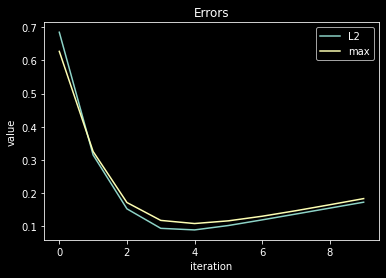

In [207]:
plt.title("Errors")
plt.plot(L2_errors, label='L2')
plt.plot(max_errors, label='max')
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()